In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/dseats_2024_validation_dataset.csv
/kaggle/input/dataset/dseats_2024_training_dataset.csv


In [2]:
#!pip install catboost -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import catboost as cbt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

# The Objective of this model is to develop a machine learning model capable of predicting the production rate of oil, gas and water using historical data, data from sensors, and operational parameters

In [4]:
#Load the data for training and model testing
Data_train = pd.read_csv("/kaggle/input/dataset/dseats_2024_training_dataset.csv")
Data_test = pd.read_csv("/kaggle/input/dataset/dseats_2024_validation_dataset.csv")

In [5]:
Data_train.head()

PRODUCTION DATE Field Name   WELL_BORE_CODE  N_WELL_BORE_CODE  \
0  07/04/2014 00:00      DSEAT  DSEAT-001-F-1 C               105   
1  08/04/2014 00:00      DSEAT  DSEAT-001-F-1 C               105   
2  09/04/2014 00:00      DSEAT  DSEAT-001-F-1 C               105   
3  10/04/2014 00:00      DSEAT  DSEAT-001-F-1 C               105   
4  11/04/2014 00:00      DSEAT  DSEAT-001-F-1 C               105   

  WellBore Name   FLOW_KIND WELL_TYPE  Downhole Pressure (PSI)  \
0     001-F-1 C  production        OP                  0.00000   
1     001-F-1 C  production        OP                  0.00000   
2     001-F-1 C  production        OP                  0.00000   
3     001-F-1 C  production        OP                  0.00000   
4     001-F-1 C  production        OP               4500.45403   

   Downhole Temperature (Kelvin)  Average Tubing Pressure  \
0                      273.15000                  0.00000   
1                      273.15000                  0.00000   
2                      273.15000                  0.00000   
3                      273.15000                  0.00000   
4                      370.02589               4020.53477   

   Annulus Pressure (PSI)  AVG WHP (PSI)  Choke Size  \
0                     0.0        0.00000     0.00000   
1                     0.0        0.00000     0.00000   
2                     0.0        0.00000     0.00000   
3                     0.0        0.00000     0.00000   
4                     0.0      479.91926    33.07195   

   Oil Production (stb/day)  Gas Volume (scf/day)  Water Production (stb/day)  
0                       0.0                   0.0                         0.0  
1                       0.0                   0.0                         0.0  
2                       0.0                   0.0                         0.0  
3                       0.0                   0.0                         0.0  
4                       0.0                   0.0                         0.0

In [6]:
Data_test

PRODUCTION DATE Field Name   WELL_BORE_CODE  N_WELL_BORE_CODE  \
0     2015-07-01 00:00:00      DSEAT  DSEAT-001-F-1 C             105.0   
1     2015-07-02 00:00:00      DSEAT  DSEAT-001-F-1 C             105.0   
2     2015-07-03 00:00:00      DSEAT  DSEAT-001-F-1 C             105.0   
3     2015-07-04 00:00:00      DSEAT  DSEAT-001-F-1 C             105.0   
4     2015-07-05 00:00:00      DSEAT  DSEAT-001-F-1 C             105.0   
...                   ...        ...              ...               ...   
9915                  NaN        NaN              NaN               NaN   
9916                  NaN        NaN              NaN               NaN   
9917                  NaN        NaN              NaN               NaN   
9918                  NaN        NaN              NaN               NaN   
9919                  NaN        NaN              NaN               NaN   

     WellBore Name   FLOW_KIND WELL_TYPE  Downhole Pressure (PSI)  \
0        001-F-1 C  production        OP              3061.253047   
1        001-F-1 C  production        OP              3247.951135   
2        001-F-1 C  production        OP              3333.012485   
3        001-F-1 C  production        OP              3404.022465   
4        001-F-1 C  production        OP              3465.473030   
...            ...         ...       ...                      ...   
9915           NaN         NaN       NaN                      NaN   
9916           NaN         NaN       NaN                      NaN   
9917           NaN         NaN       NaN                      NaN   
9918           NaN         NaN       NaN                      NaN   
9919           NaN         NaN       NaN                      NaN   

      Downhole Temperature (Kelvin)  Average Tubing Pressure  \
0                        380.665745              2659.809580   
1                        376.759980              2547.453670   
2                        375.985300              2533.912265   
3                        375.419010              2481.804485   
4                        375.004710              2408.310945   
...                             ...                      ...   
9915                            NaN                      NaN   
9916                            NaN                      NaN   
9917                            NaN                      NaN   
9918                            NaN                      NaN   
9919                            NaN                      NaN   

      Annulus Pressure (PSI)  AVG WHP (PSI)  Choke Size  \
0                        0.0     401.443468    0.491632   
1                        0.0     700.497465   21.775180   
2                        0.0     799.100220   27.638780   
3                        0.0     922.217980   36.178940   
4                        0.0    1057.162085   45.424140   
...                      ...            ...         ...   
9915                     NaN            NaN         NaN   
9916                     NaN            NaN         NaN   
9917                     NaN            NaN         NaN   
9918                     NaN            NaN         NaN   
9919                     NaN            NaN         NaN   

      Oil Production (stb/day)  Gas Volume (scf/day)  \
0                          NaN                   NaN   
1                          NaN                   NaN   
2                          NaN                   NaN   
3                          NaN                   NaN   
4                          NaN                   NaN   
...                        ...                   ...   
9915                       NaN                   NaN   
9916                       NaN                   NaN   
9917                       NaN                   NaN   
9918                       NaN                   NaN   
9919                       NaN                   NaN   

      Water Production (stb/day)  
0                            NaN  
1                            NaN  
2                       

In [7]:
Data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9920 entries, 0 to 9919
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PRODUCTION DATE                2075 non-null   object 
 1   Field Name                     2075 non-null   object 
 2   WELL_BORE_CODE                 2075 non-null   object 
 3   N_WELL_BORE_CODE               2075 non-null   float64
 4   WellBore Name                  2075 non-null   object 
 5   FLOW_KIND                      2075 non-null   object 
 6   WELL_TYPE                      2075 non-null   object 
 7   Downhole Pressure (PSI)        2075 non-null   float64
 8   Downhole Temperature (Kelvin)  2075 non-null   float64
 9   Average Tubing Pressure        2075 non-null   float64
 10  Annulus Pressure (PSI)         2075 non-null   float64
 11  AVG WHP (PSI)                  2075 non-null   float64
 12  Choke Size                     2075 non-null   f

In [8]:
# convert the date column to the datetime object and set as index
Data_train['PRODUCTION_DATE'] = pd.to_datetime(Data_train['PRODUCTION DATE'], format='%d/%m/%Y %H:%M')
Data_train['Date'] = pd.to_datetime(Data_train['PRODUCTION_DATE'].dt.date)
Data_train.set_index('Date', inplace=True)
Data_train = Data_train.drop(['PRODUCTION DATE','PRODUCTION_DATE'], axis=1)

#========================================================================================================#

Data_test['PRODUCTION_DATE'] = pd.to_datetime(Data_test['PRODUCTION DATE'], format='%Y-%m-%d %H:%M:%S')
Data_test['Date'] = pd.to_datetime(Data_test['PRODUCTION_DATE'].dt.date)
Data_test.set_index('Date', inplace=True)
Data_test = Data_test.drop(['PRODUCTION DATE','PRODUCTION_DATE'], axis=1)

In [9]:
# convert the date column to the datetime object and set as index
display("Train Data", Data_train.head(), "Test Data", Data_test.head())

'Train Data'

Field Name   WELL_BORE_CODE  N_WELL_BORE_CODE WellBore Name  \
Date                                                                     
2014-04-07      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
2014-04-08      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
2014-04-09      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
2014-04-10      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
2014-04-11      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   

             FLOW_KIND WELL_TYPE  Downhole Pressure (PSI)  \
Date                                                        
2014-04-07  production        OP                  0.00000   
2014-04-08  production        OP                  0.00000   
2014-04-09  production        OP                  0.00000   
2014-04-10  production        OP                  0.00000   
2014-04-11  production        OP               4500.45403   

            Downhole Temperature (Kelvin)  Average Tubing Pressure  \
Date                                                                 
2014-04-07                      273.15000                  0.00000   
2014-04-08                      273.15000                  0.00000   
2014-04-09                      273.15000                  0.00000   
2014-04-10                      273.15000                  0.00000   
2014-04-11                      370.02589               4020.53477   

            Annulus Pressure (PSI)  AVG WHP (PSI)  Choke Size  \
Date                                                            
2014-04-07                     0.0        0.00000     0.00000   
2014-04-08                     0.0        0.00000     0.00000   
2014-04-09                     0.0        0.00000     0.00000   
2014-04-10                     0.0        0.00000     0.00000   
2014-04-11                     0.0      479.91926    33.07195   

            Oil Production (stb/day)  Gas Volume (scf/day)  \
Date                                                         
2014-04-07                       0.0                   0.0   
2014-04-08                       0.0                   0.0   
2014-04-09                       0.0                   0.0   
2014-04-10                       0.0                   0.0   
2014-04-11                       0.0                   0.0   

            Water Production (stb/day)  
Date                                    
2014-04-07                         0.0  
2014-04-08                         0.0  
2014-04-09                         0.0  
2014-04-10                         0.0  
2014-04-11                         0.0

'Test Data'

Field Name   WELL_BORE_CODE  N_WELL_BORE_CODE WellBore Name  \
Date                                                                     
2015-07-01      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-02      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-03      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-04      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-05      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   

             FLOW_KIND WELL_TYPE  Downhole Pressure (PSI)  \
Date                                                        
2015-07-01  production        OP              3061.253047   
2015-07-02  production        OP              3247.951135   
2015-07-03  production        OP              3333.012485   
2015-07-04  production        OP              3404.022465   
2015-07-05  production        OP              3465.473030   

            Downhole Temperature (Kelvin)  Average Tubing Pressure  \
Date                                                                 
2015-07-01                     380.665745              2659.809580   
2015-07-02                     376.759980              2547.453670   
2015-07-03                     375.985300              2533.912265   
2015-07-04                     375.419010              2481.804485   
2015-07-05                     375.004710              2408.310945   

            Annulus Pressure (PSI)  AVG WHP (PSI)  Choke Size  \
Date                                                            
2015-07-01                     0.0     401.443468    0.491632   
2015-07-02                     0.0     700.497465   21.775180   
2015-07-03                     0.0     799.100220   27.638780   
2015-07-04                     0.0     922.217980   36.178940   
2015-07-05                     0.0    1057.162085   45.424140   

            Oil Production (stb/day)  Gas Volume (scf/day)  \
Date                                                         
2015-07-01                       NaN                   NaN   
2015-07-02                       NaN                   NaN   
2015-07-03                       NaN                   NaN   
2015-07-04                       NaN                   NaN   
2015-07-05                       NaN                   NaN   

            Water Production (stb/day)  
Date                                    
2015-07-01                         NaN  
2015-07-02                         NaN  
2015-07-03                         NaN  
2015-07-04                         NaN  
2015-07-05                         NaN

In [10]:
#Lets findout if the dates in the data is increasing daily
train_daily = Data_train.copy()
train_daily.reset_index().groupby("WELL_BORE_CODE").agg(Start_Date=("Date","min"), End_Date=("Date","max"))
train_daily["date_diff"] = train_daily.index.to_series().diff().dt.days  # Get difference in days
train_daily["is_daily"] = train_daily["date_diff"] == 1  # Check if the difference is exactly 1 day


test_daily = Data_test.copy()
test_daily.reset_index().groupby("WELL_BORE_CODE").agg(Start_Date=("Date","min"), End_Date=("Date","max"))
test_daily["date_diff"] = test_daily.index.to_series().diff().dt.days  # Get difference in days
test_daily["is_daily"] = test_daily["date_diff"] == 1  # Check if the difference is exactly 1 day

In [11]:
test_daily[test_daily["WELL_BORE_CODE"] == "DSEAT-001-F-1 C"]

Field Name   WELL_BORE_CODE  N_WELL_BORE_CODE WellBore Name  \
Date                                                                     
2015-07-01      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-02      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-03      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-04      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-05      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
...               ...              ...               ...           ...   
2016-04-17      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2016-04-18      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2016-04-19      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2016-04-20      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2016-04-21      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   

             FLOW_KIND WELL_TYPE  Downhole Pressure (PSI)  \
Date                                                        
2015-07-01  production        OP              3061.253047   
2015-07-02  production        OP              3247.951135   
2015-07-03  production        OP              3333.012485   
2015-07-04  production        OP              3404.022465   
2015-07-05  production        OP              3465.473030   
...                ...       ...                      ...   
2016-04-17  production        OP              3918.893105   
2016-04-18  production        OP              4014.599775   
2016-04-19  production        OP              4090.528010   
2016-04-20  production        OP              4133.888665   
2016-04-21  production        OP                 0.000000   

            Downhole Temperature (Kelvin)  Average Tubing Pressure  \
Date                                                                 
2015-07-01                     380.665745              2659.809580   
2015-07-02                     376.759980              2547.453670   
2015-07-03                     375.985300              2533.912265   
2015-07-04                     375.419010              2481.804485   
2015-07-05                     375.004710              2408.310945   
...                                   ...                      ...   
2016-04-17                     374.348070              3824.670075   
2016-04-18                     374.381020              3815.747210   
2016-04-19                     374.327540              3966.179055   
2016-04-20                     374.281420              3868.824895   
2016-04-21                     273.150000                 0.000000   

            Annulus Pressure (PSI)  AVG WHP (PSI)  Choke Size  \
Date                                                            
2015-07-01                     0.0     401.443468    0.491632   
2015-07-02                     0.0     700.497465   21.775180   
2015-07-03                     0.0     799.100220   27.638780   
2015-07-04                     0.0     922.217980   36.178940   
2015-07-05                     0.0    1057.162085   45.424140   
...                            ...            ...         ...   
2016-04-17                     0.0      94.223030    2.645280   
2016-04-18                     0.0     198.852565    4.120000   
2016-04-19                     0.0     124.348955    1.866280   
2016-04-20                     0.0     265.063770    7.413910   
2016-04-21                     0.0       0.000000    0.000000   

            Oil Production (stb/day)  Gas Volume (scf/day)  \
Date                                                         
2015-07-01                       NaN                   NaN   
2015-07-02                       NaN                   NaN   
2015-07-03                       NaN                   NaN   
2015-07-04                       NaN                   NaN   
2015-07-05                       NaN                   NaN   
...                              ...                   ...   
2

In [12]:
is_daily = train_daily.loc[:, ["date_diff", "is_daily"]]
is_daily.head(15)

date_diff  is_daily
Date                           
2014-04-07        NaN     False
2014-04-08        1.0      True
2014-04-09        1.0      True
2014-04-10        1.0      True
2014-04-11        1.0      True
2014-04-12        1.0      True
2014-04-13        1.0      True
2014-04-14        1.0      True
2014-04-15        1.0      True
2014-04-16        1.0      True
2014-04-17        1.0      True
2014-04-18        1.0      True
2014-04-19        1.0      True
2014-04-20        1.0      True
2014-04-21        1.0      True

In [13]:
#is_test_daily = test_daily.loc[:, ["date_diff", "is_daily"]]
#is_test_daily.head(15)

As displayed above, we can see that the production data increases daily

In [14]:
#Data_train.index.dtype

In [15]:
Data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6925 entries, 2014-04-07 to 2015-06-30
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Field Name                     6925 non-null   object 
 1   WELL_BORE_CODE                 6925 non-null   object 
 2   N_WELL_BORE_CODE               6925 non-null   int64  
 3   WellBore Name                  6925 non-null   object 
 4   FLOW_KIND                      6925 non-null   object 
 5   WELL_TYPE                      6925 non-null   object 
 6   Downhole Pressure (PSI)        6925 non-null   float64
 7   Downhole Temperature (Kelvin)  6925 non-null   float64
 8   Average Tubing Pressure        6925 non-null   float64
 9   Annulus Pressure (PSI)         6925 non-null   float64
 10  AVG WHP (PSI)                  6925 non-null   float64
 11  Choke Size                     6919 non-null   float64
 12  Oil Production (stb/day)      

In [16]:
#Descriptive statistics
Data_train.describe().T

count          mean           std        min  \
N_WELL_BORE_CODE               6925.0  1.072970e+02  9.801606e-01   105.0000   
Downhole Pressure (PSI)        6925.0  2.587483e+03  1.588474e+03     0.0000   
Downhole Temperature (Kelvin)  6925.0  3.496748e+02  4.624082e+01   273.1500   
Average Tubing Pressure        6925.0  2.161986e+03  1.053875e+03     0.0000   
Annulus Pressure (PSI)         6925.0  1.803694e+02  1.397715e+02     0.0000   
AVG WHP (PSI)                  6925.0  7.165769e+02  3.478600e+02     0.0000   
Choke Size                     6919.0  2.186456e+01  2.230069e+01     0.0000   
Oil Production (stb/day)       6925.0  8.494775e+03  8.927597e+03     0.0000   
Gas Volume (scf/day)           6925.0  6.978690e+06  7.100875e+06     0.0000   
Water Production (stb/day)     6925.0  1.148056e+04  1.148448e+04 -2879.8136   

                                        25%           50%           75%  \
N_WELL_BORE_CODE               1.070000e+02  1.070000e+02  1.080000e+02   
Downhole Pressure (PSI)        0.000000e+00  3.378397e+03  3.664905e+03   
Downhole Temperature (Kelvin)  2.731500e+02  3.769114e+02  3.794962e+02   
Average Tubing Pressure        8.966123e+02  2.472032e+03  2.907047e+03   
Annulus Pressure (PSI)         0.000000e+00  2.130911e+02  3.003568e+02   
AVG WHP (PSI)                  4.765398e+02  6.196478e+02  9.038905e+02   
Choke Size                     4.631982e+00  1.430166e+01  3.152977e+01   
Oil Production (stb/day)       1.686601e+03  5.479471e+03  1.173047e+04   
Gas Volume (scf/day)           1.434288e+06  4.770461e+06  9.892230e+06   
Water Production (stb/day)     8.032330e+01  5.529413e+03  2.226151e+04   

                                        max  
N_WELL_BORE_CODE               1.090000e+02  
Downhole Pressure (PSI)        4.606667e+03  
Downhole Temperature (Kelvin)  3.816522e+02  
Average Tubing Pressure        4.592613e+03  
Annulus Pressure (PSI)         4.352875e+02  
AVG WHP (PSI)                  1.991010e+03  
Choke Size                     1.257186e+02  
Oil Production (stb/day)       3.712257e+04  
Gas Volume (scf/day)           3.004494e+07  
Water Production (stb/day)     5.044416e+04

We can immediately see that we have negative values in the water production column. This needs to be handled because we cannot have negative values for water production.
We can also see that our data contains some missing values in the Choke Size column as seen below.

In [17]:
#check for missing values
Data_train.isna().sum()

Field Name                       0
WELL_BORE_CODE                   0
N_WELL_BORE_CODE                 0
WellBore Name                    0
FLOW_KIND                        0
WELL_TYPE                        0
Downhole Pressure (PSI)          0
Downhole Temperature (Kelvin)    0
Average Tubing Pressure          0
Annulus Pressure (PSI)           0
AVG WHP (PSI)                    0
Choke Size                       6
Oil Production (stb/day)         0
Gas Volume (scf/day)             0
Water Production (stb/day)       0
dtype: int64

Remove the negative values in Water Production Column, missing values in choke size column and replace with the previous choke size value, since the missing values are very few compared to the data we have. For our time series its important not to disrupt the daily pattern in our data

In [18]:
neg_val = Data_train[(Data_train['Oil Production (stb/day)']<0) | (Data_train['Gas Volume (scf/day)']<0) | (Data_train['Water Production (stb/day)']<0)]

print("Data Entries with Negative Production values:")
neg_val

Data Entries with Negative Production values:


Field Name    WELL_BORE_CODE  N_WELL_BORE_CODE WellBore Name  \
Date                                                                      
2008-04-23      DSEAT  DSEAT-001-F-12 H               107      001-F-12   
2012-08-13      DSEAT  DSEAT-001-F-12 H               107      001-F-12   
2009-03-03      DSEAT  DSEAT-001-F-14 H               108      001-F-14   
2012-08-13      DSEAT  DSEAT-001-F-14 H               108      001-F-14   

             FLOW_KIND WELL_TYPE  Downhole Pressure (PSI)  \
Date                                                        
2008-04-23  production        OP              3778.090061   
2012-08-13  production        OP                 0.000000   
2009-03-03  production        OP              3919.223637   
2012-08-13  production        OP              3666.939046   

            Downhole Temperature (Kelvin)  Average Tubing Pressure  \
Date                                                                 
2008-04-23                     378.921069              2446.120354   
2012-08-13                     273.150000               738.789964   
2009-03-03                     378.613575              2440.423694   
2012-08-13                     375.036570              2997.727129   

            Annulus Pressure (PSI)  AVG WHP (PSI)  Choke Size  \
Date                                                            
2008-04-23              159.654201    1331.969707   60.253108   
2012-08-13              149.643422     738.789964   21.297284   
2009-03-03                0.000000    1478.799943   68.800869   
2012-08-13              214.782410     669.211917   17.203700   

            Oil Production (stb/day)  Gas Volume (scf/day)  \
Date                                                         
2008-04-23                17206.4837          1.490066e+07   
2012-08-13                 3981.3184          4.279550e+05   
2009-03-03                27293.1277          2.174814e+07   
2012-08-13                 1273.9137          1.325204e+05   

            Water Production (stb/day)  
Date                                    
2008-04-23                    -89.2551  
2012-08-13                  -2879.8136  
2009-03-03                     -5.9755  
2012-08-13                   -372.3051

In [19]:
#Use machine learning(unsupervised learning) to replace the negative values in the water production column
from sklearn.impute import KNNImputer

Data_train.loc[Data_train["Water Production (stb/day)"]< 0,"Water Production (stb/day)"] = np.nan
imputer = KNNImputer(n_neighbors=7, weights="uniform")
Data_train[["Water Production (stb/day)"]] = imputer.fit_transform(Data_train[["Water Production (stb/day)"]])

In [20]:
#Lets do the same for choke size, fill the missing values using unsupervised learning
Data_train[["Choke Size"]] = imputer.fit_transform(Data_train[["Choke Size"]])

In [21]:
# To crosscheck and ensure our data doesn't contain negative values
def contains_negative_values(Data):
    return (Data.select_dtypes(include=[int, float]) < 0).any().any()

if contains_negative_values(Data_train):
    print("The DataFrame contains negative values.")
else:
    print("The DataFrame does not contain negative values.")

The DataFrame does not contain negative values.


# Lets Visualize Our Data.



Group the data by well bore code inorder to visualize the data for each well

In [22]:
#DSEAT-001-F-1 C = Well A, DSEAT-001-F-11 = Well B, DSEAT-001-F-12 H = Well C, DSEAT-001-F-14 H = Well D, DSEAT-001-F-15 D = Well E

Well_A = Data_train.loc[Data_train["WELL_BORE_CODE"]=="DSEAT-001-F-1 C", :]
Well_B = Data_train.loc[Data_train["WELL_BORE_CODE"]=="DSEAT-001-F-11 H", :]
Well_C = Data_train.loc[Data_train["WELL_BORE_CODE"]=="DSEAT-001-F-12 H", :]
Well_D = Data_train.loc[Data_train["WELL_BORE_CODE"]=="DSEAT-001-F-14 H", :]
Well_E = Data_train.loc[Data_train["WELL_BORE_CODE"]=="DSEAT-001-F-15 D", :]

- Visualize the distributions of each numerical features

- Visualize how Downhole pressure, Downhole temperature, Average Tubing Pressure, Annulus pressure, Avg WHP, and Choke size affect water, oil and gas production

- Visualize the production trend for each well(Well C)

- Heatmap Correlation of the Data

In [23]:
num_features = ['Downhole Pressure (PSI)','Downhole Temperature (Kelvin)', 'Average Tubing Pressure','Annulus Pressure (PSI)',
                'AVG WHP (PSI)', 'Choke Size']

target_features = ['Oil Production (stb/day)', 'Gas Volume (scf/day)','Water Production (stb/day)']
features = num_features + target_features

In [24]:
def visualize_numeric_distributions(df, features, title="Feature Distributions"):
    
    plt.figure(figsize=(15, 5 * len(features) // 3))
    
    for i, feature in enumerate(features):
        plt.subplot(len(features) // 3 + 1, 3, i + 1)
        sns.histplot(df[feature], kde=True, bins=30, color="blue")
        plt.title(f"Distribution of {feature}")
        plt.xlabel("")
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_numeric_distributions(Data_train, num_features, title="Numeric Feature Distributions")

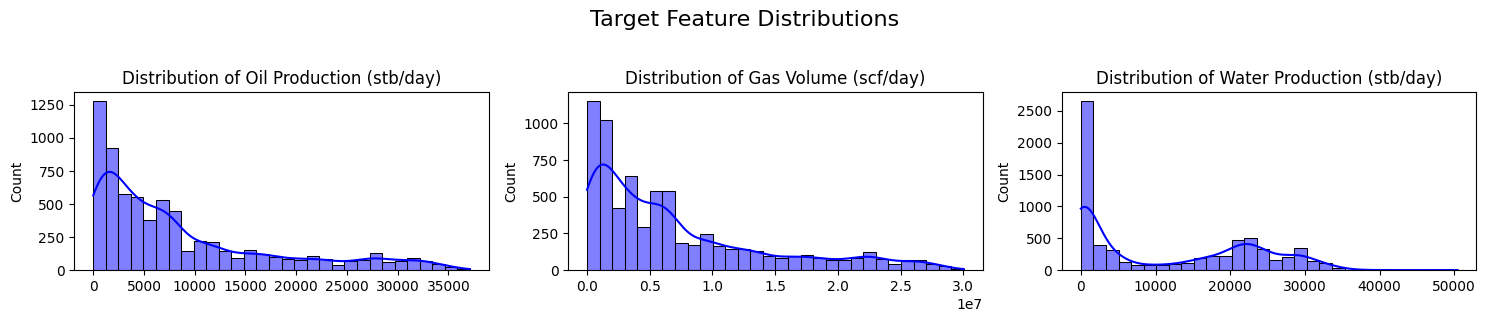

In [26]:
visualize_numeric_distributions(Data_train, target_features, title="Target Feature Distributions")

In [27]:
def plot_feature_relationships(df, num_features, target_features):
    plt.figure(figsize=(15, 5 * len(num_features)))
    
    for i, num_feat in enumerate(num_features):
        for j, target_feat in enumerate(target_features):
            plt.subplot(len(num_features), len(target_features), i * len(target_features) + j + 1)
            sns.regplot(x=df[num_feat], y=df[target_feat], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
            plt.title(f"{num_feat} vs {target_feat}")
    
    plt.tight_layout()
    plt.show()

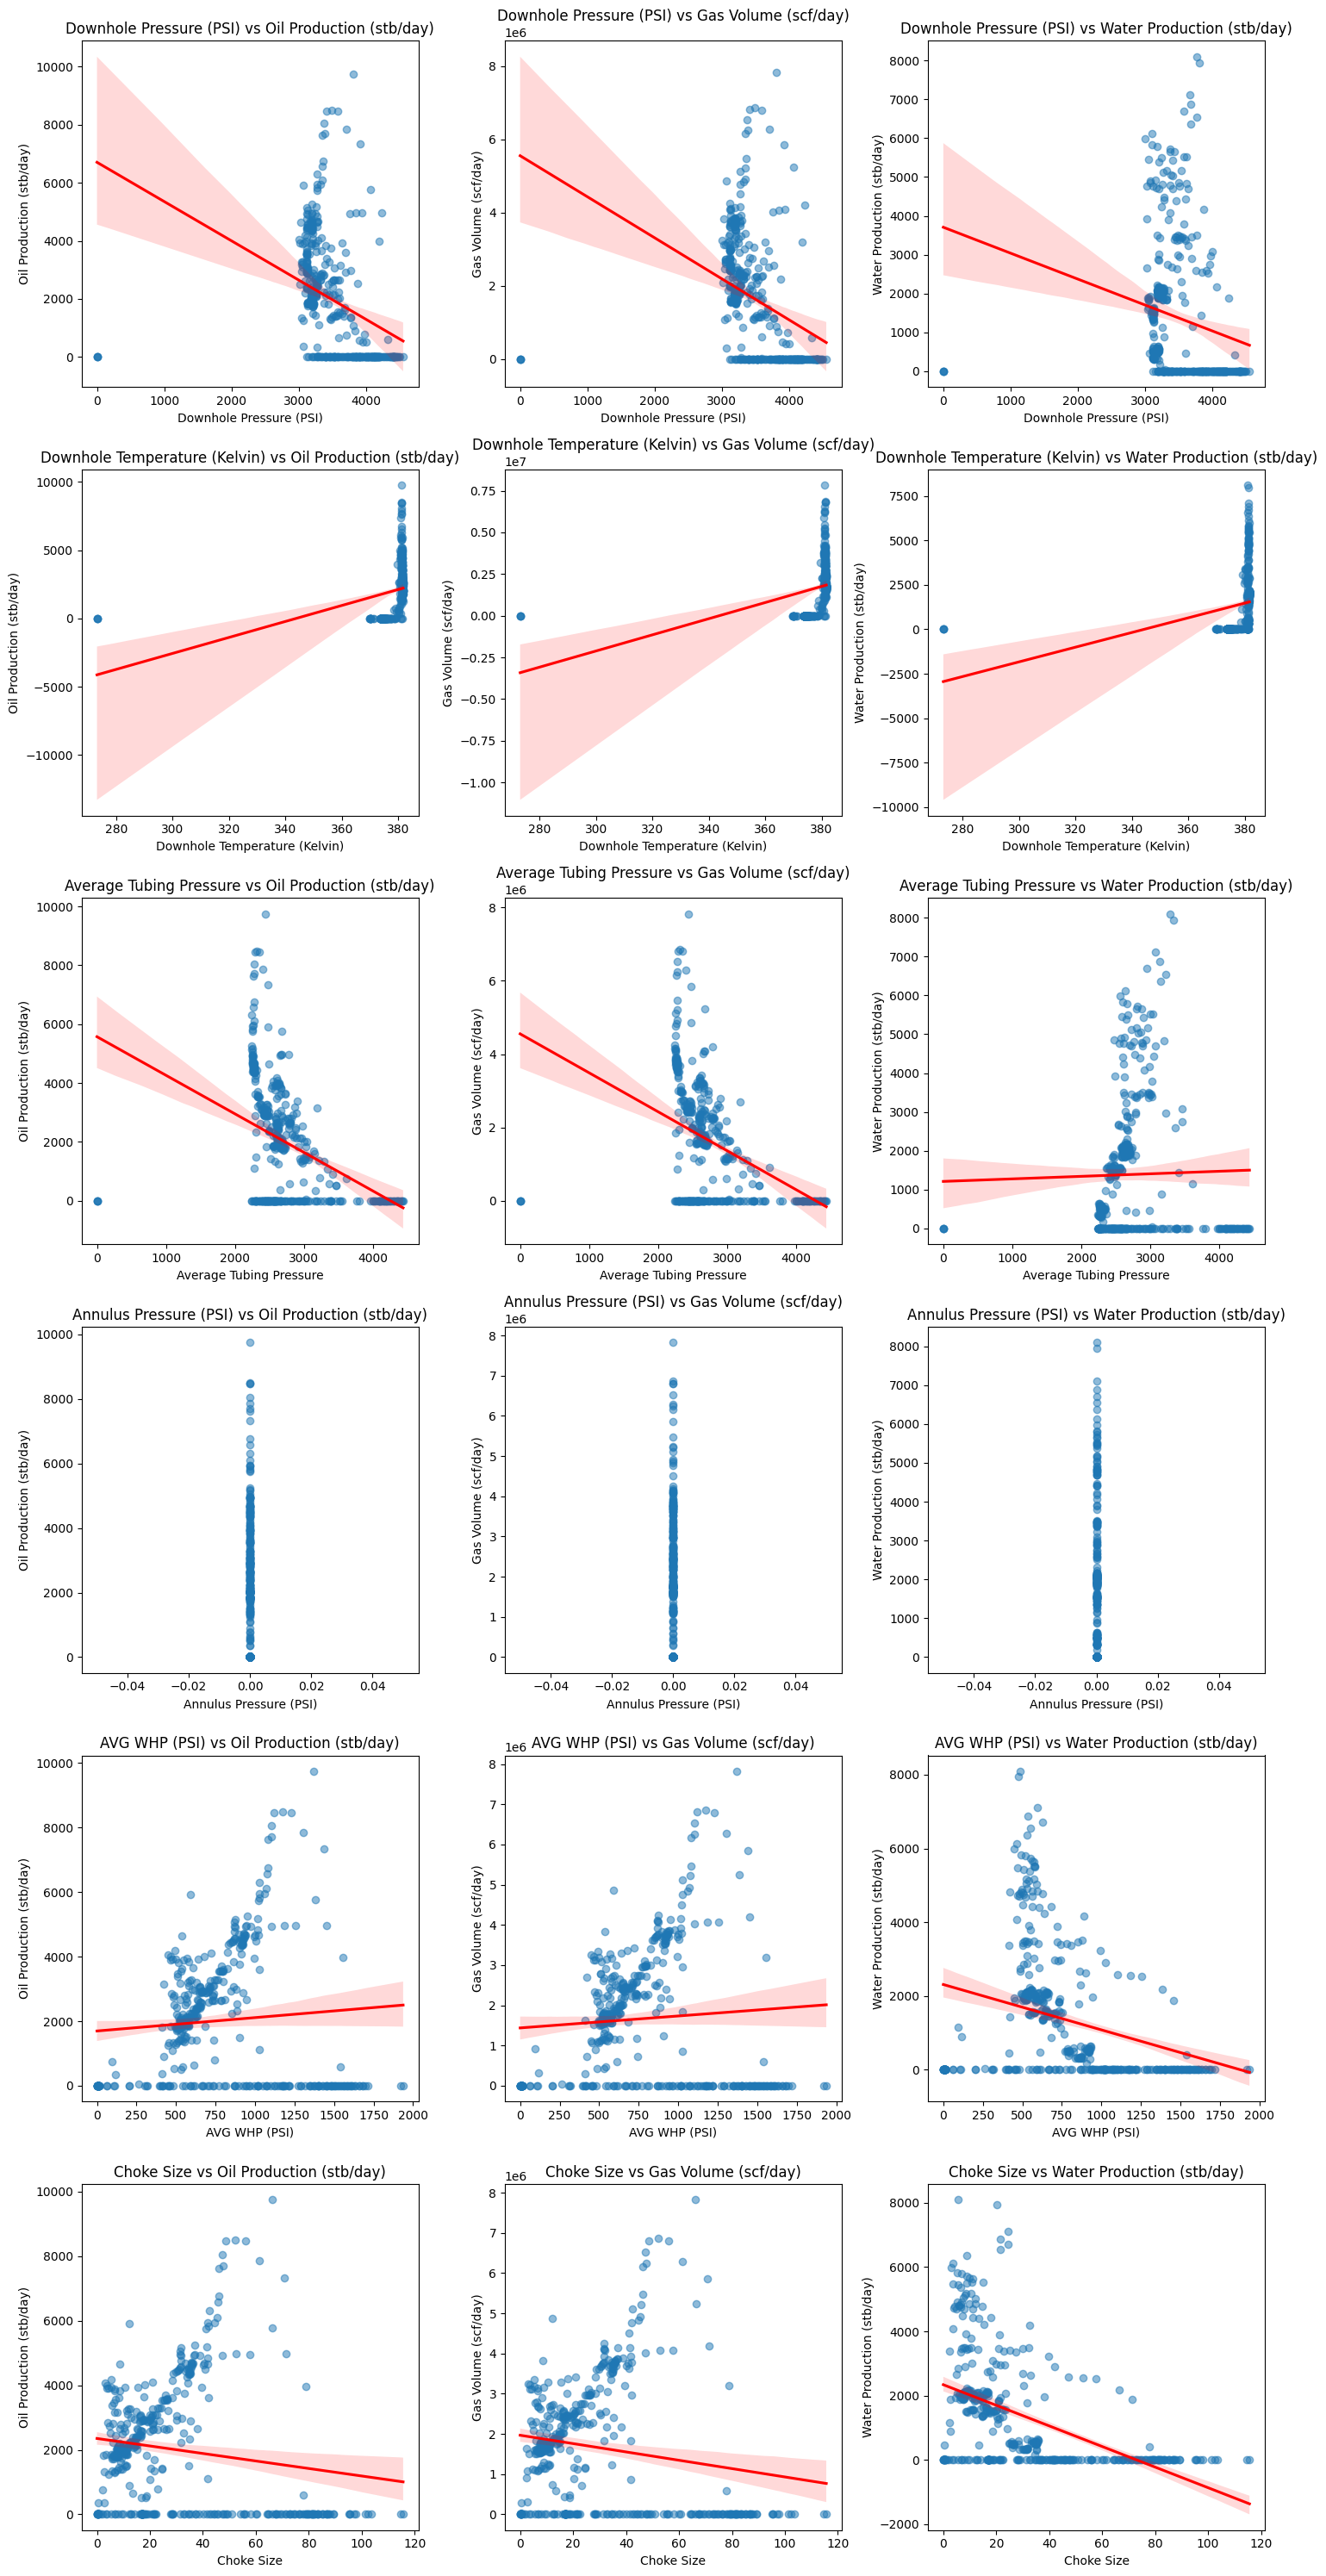

In [28]:
# Call the function
plot_feature_relationships(Well_A, num_features, target_features)

In [ ]:
# Call the function
plot_feature_relationships(Well_B, num_features, target_features)

In [ ]:
# Call the function
plot_feature_relationships(Well_C, num_features, target_features)

In [31]:
# Call the function
plot_feature_relationships(Well_D, num_features, target_features)

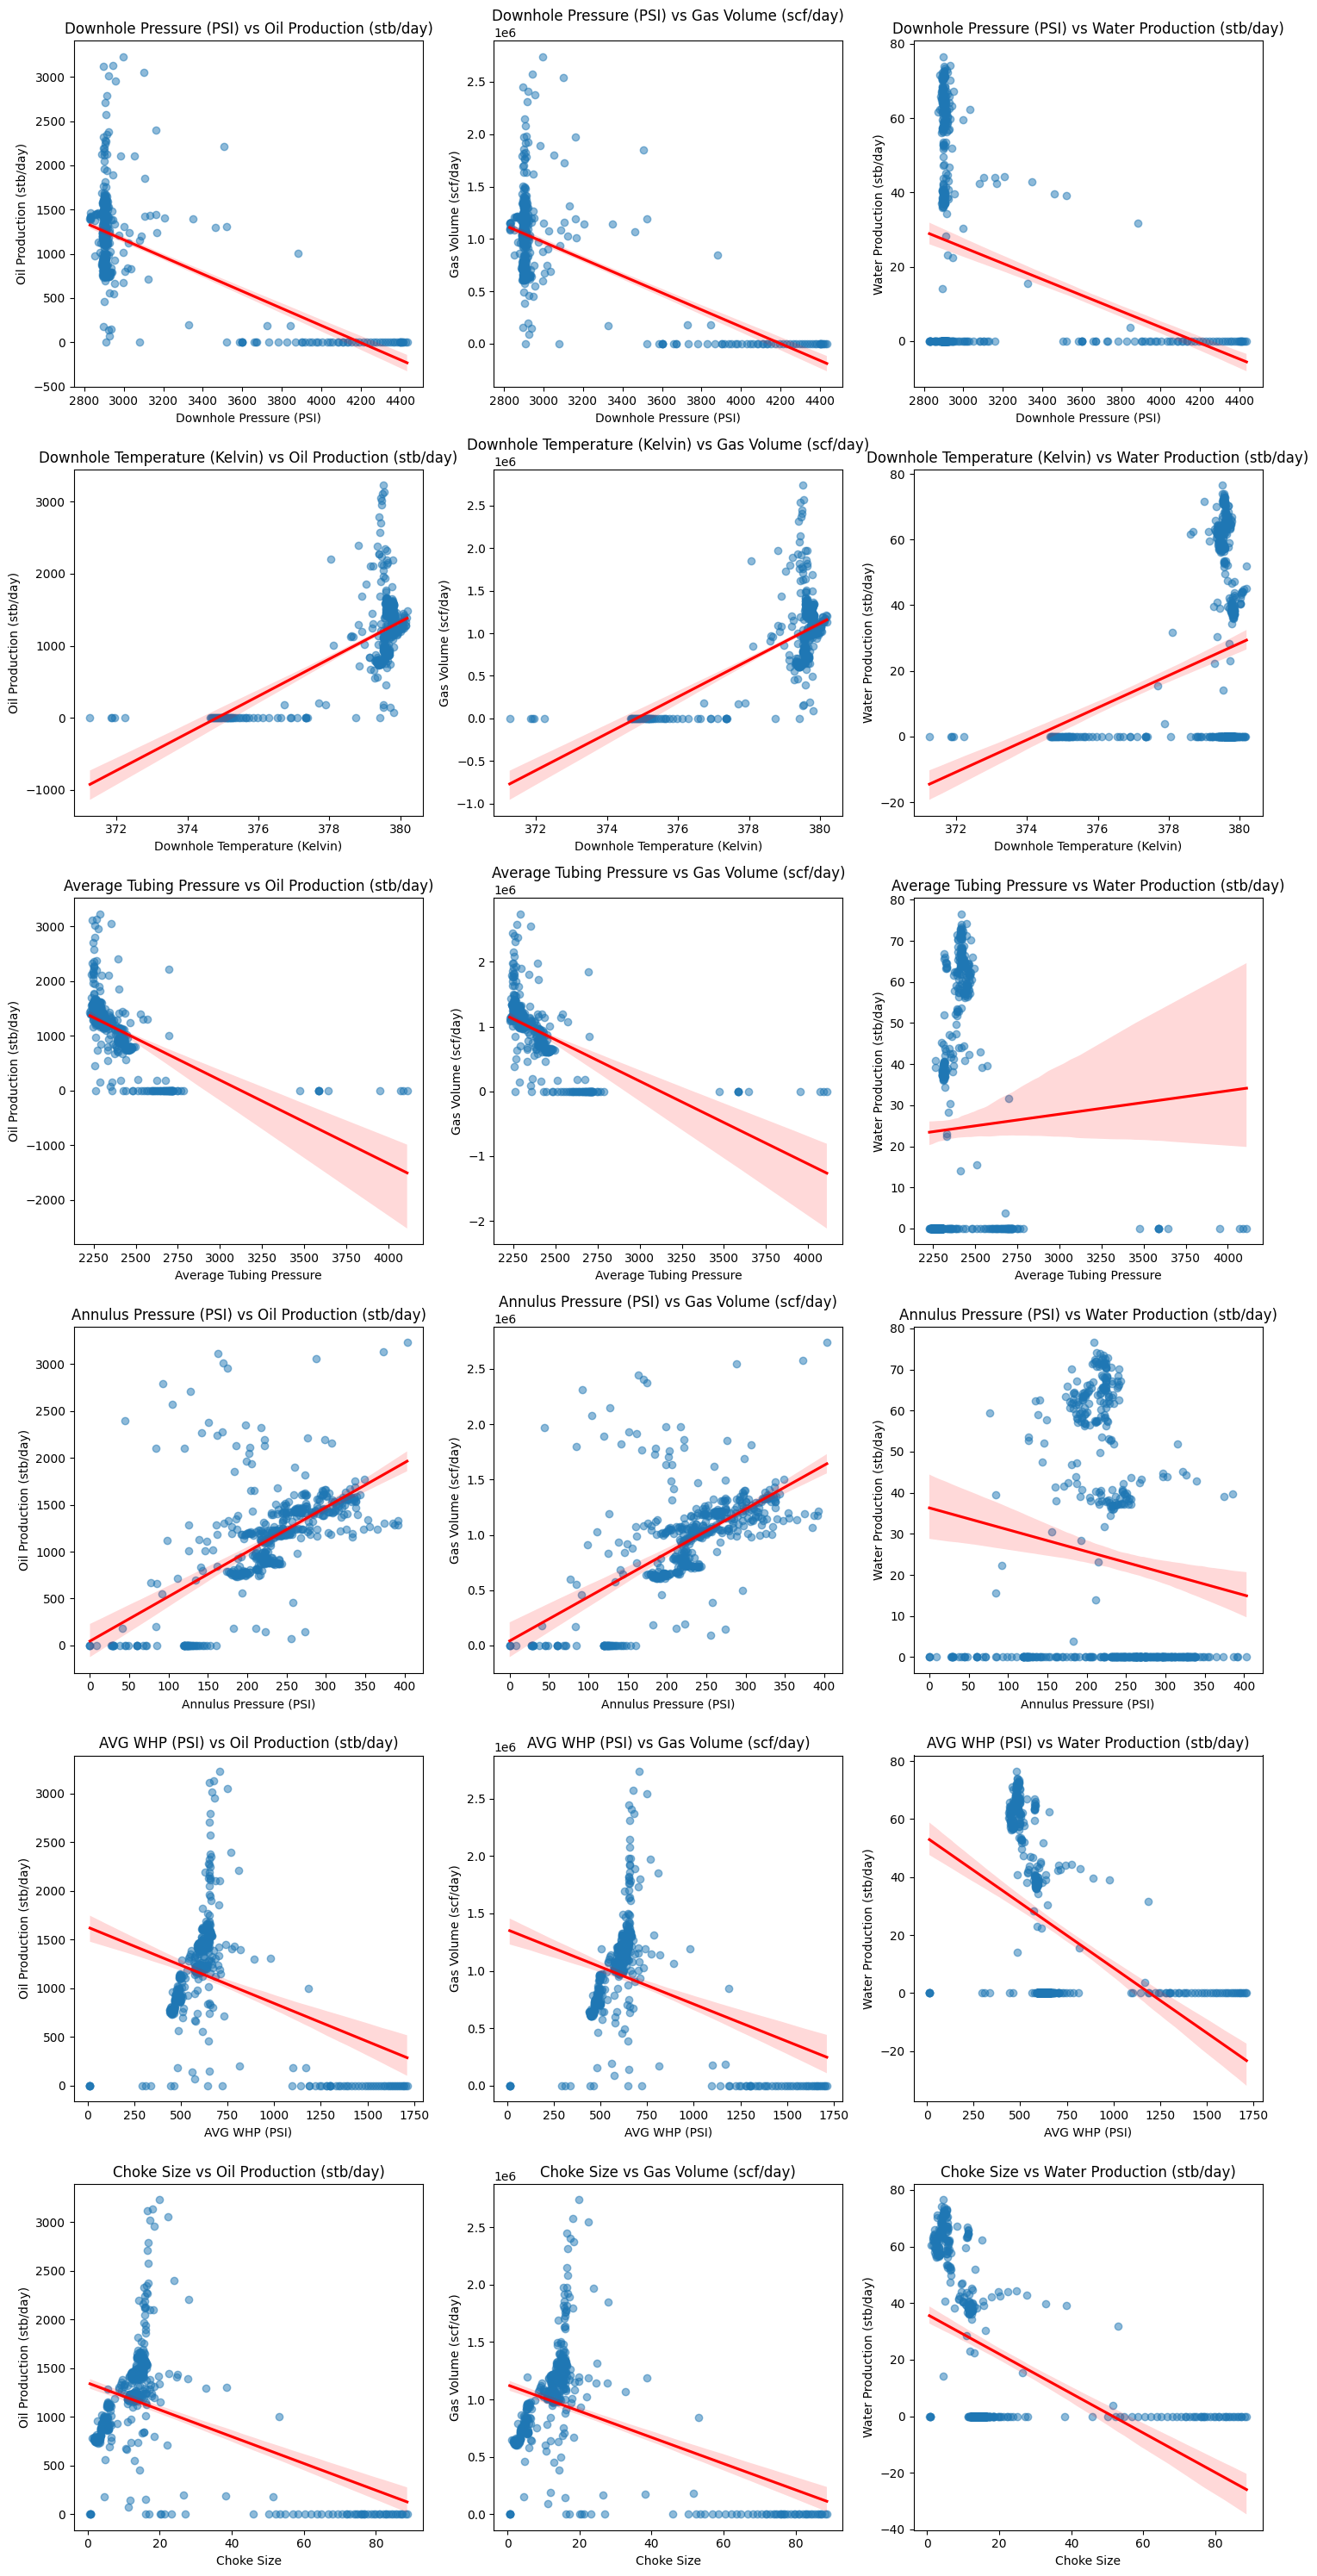

In [32]:
# Call the function
plot_feature_relationships(Well_E, num_features, target_features)

In [33]:
def plot_oil_production_trend(df):
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(df.index, df['Oil Production (stb/day)'], label="Oil Production", color="tab:blue", linewidth=2)
    
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Oil Production (stb/day)", fontsize=12)
    plt.title("Oil Production Trend Over Time", fontsize=14, fontweight="bold")
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)  
    plt.show()

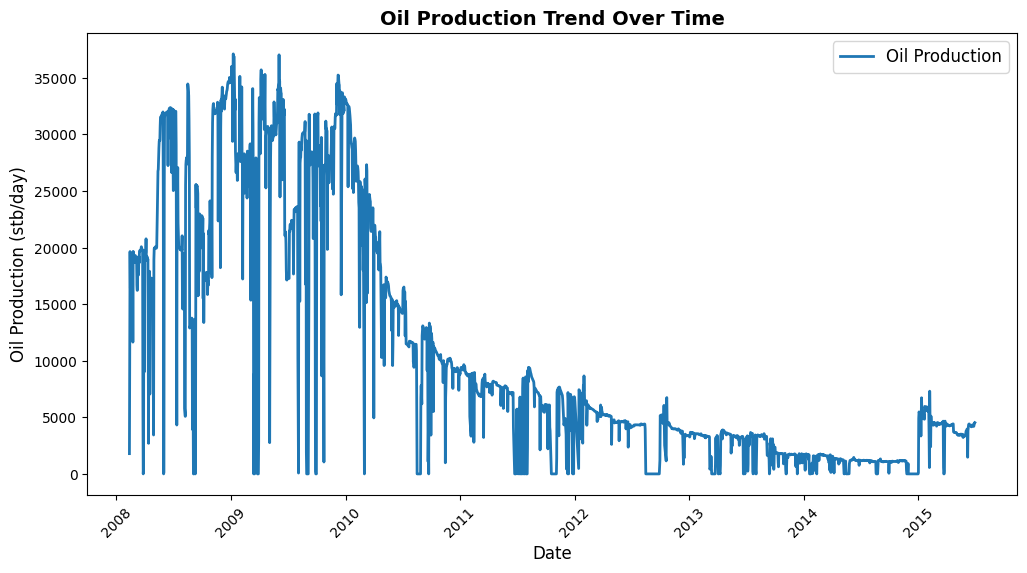

In [34]:
# Call the function to visualize the oil production trend in Well C
# To see the oil production trend for other well, just substitute well C for the desired well
plot_oil_production_trend(Well_C)

In [35]:
#Calculate the avg value for each feature in each well data
avg_well_values = Data_train.groupby('WELL_BORE_CODE')[features].mean()
print("Average Well Values", end="\n\n")
avg_well_values

Average Well Values



Downhole Pressure (PSI)  Downhole Temperature (Kelvin)  \
WELL_BORE_CODE                                                             
DSEAT-001-F-1 C               3472.238874                     377.993464   
DSEAT-001-F-11 H              3336.631369                     375.861340   
DSEAT-001-F-12 H              1367.385376                     312.039633   
DSEAT-001-F-14 H              3355.996499                     369.186599   
DSEAT-001-F-15 D              3040.688727                     379.172667   

                  Average Tubing Pressure  Annulus Pressure (PSI)  \
WELL_BORE_CODE                                                      
DSEAT-001-F-1 C               2722.663294                0.000000   
DSEAT-001-F-11 H              2434.615093              277.405610   
DSEAT-001-F-12 H              1373.110334              246.396736   
DSEAT-001-F-14 H              2732.476826              109.440022   
DSEAT-001-F-15 D              2390.142599              225.583788   

                  AVG WHP (PSI)  Choke Size  Oil Production (stb/day)  \
WELL_BORE_CODE                                                          
DSEAT-001-F-1 C      749.575581   29.591942               2007.602503   
DSEAT-001-F-11 H     903.068453   35.090111               6773.676102   
DSEAT-001-F-12 H     751.512157   22.369539              10726.171860   
DSEAT-001-F-14 H     638.007385   17.443374               9361.722560   
DSEAT-001-F-15 D     650.546128   16.659070               1118.861778   

                  Gas Volume (scf/day)  Water Production (stb/day)  
WELL_BORE_CODE                                                      
DSEAT-001-F-1 C           1.661200e+06                 1390.235089  
DSEAT-001-F-11 H          5.713681e+06                 1758.928174  
DSEAT-001-F-12 H          8.759111e+06                15315.893268  
DSEAT-001-F-14 H          7.696858e+06                14422.581470  
DSEAT-001-F-15 D          9.371485e+05                   24.352095

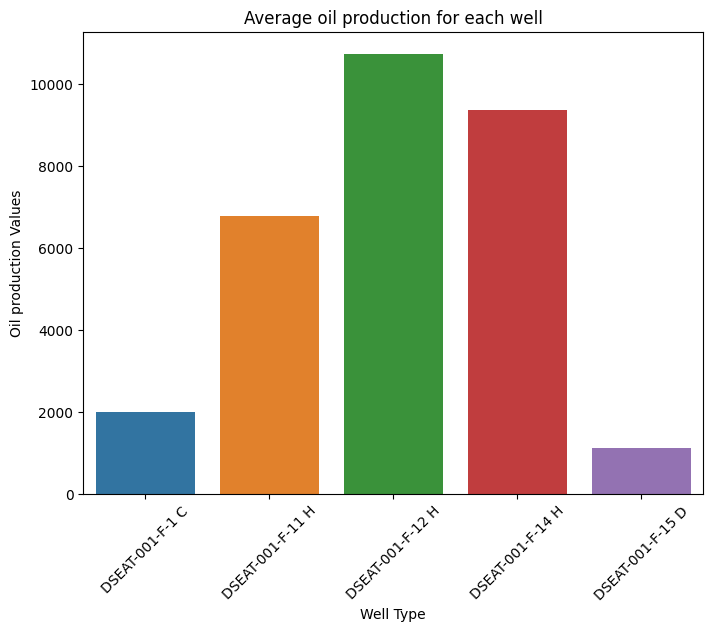

In [36]:
plt.figure(figsize=(8,6))

sns.barplot(x=avg_well_values.index,y=avg_well_values["Oil Production (stb/day)"])
plt.title("Average oil production for each well")
plt.xlabel("Well Type")
plt.ylabel("Oil production Values")
plt.xticks(rotation=45)
plt.show()

In [37]:
def cdf(df, well_column, production_columns):
    wells = df[well_column].unique()
    
    fig, axes = plt.subplots(len(production_columns), 1, figsize=(10, 6 * len(production_columns)))

    if len(production_columns) == 1:
        axes = [axes]

    for idx, production_column in enumerate(production_columns):
        for well in wells:
            well_data = df[df[well_column] == well]
            sorted_data = np.sort(well_data[production_column])
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            axes[idx].plot(sorted_data, cdf, label=f'Well {well}')
        
        axes[idx].set_title(f'Cumulative Density Function for {production_column}')
        axes[idx].set_xlabel(production_column)
        axes[idx].set_ylabel('CDF')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()

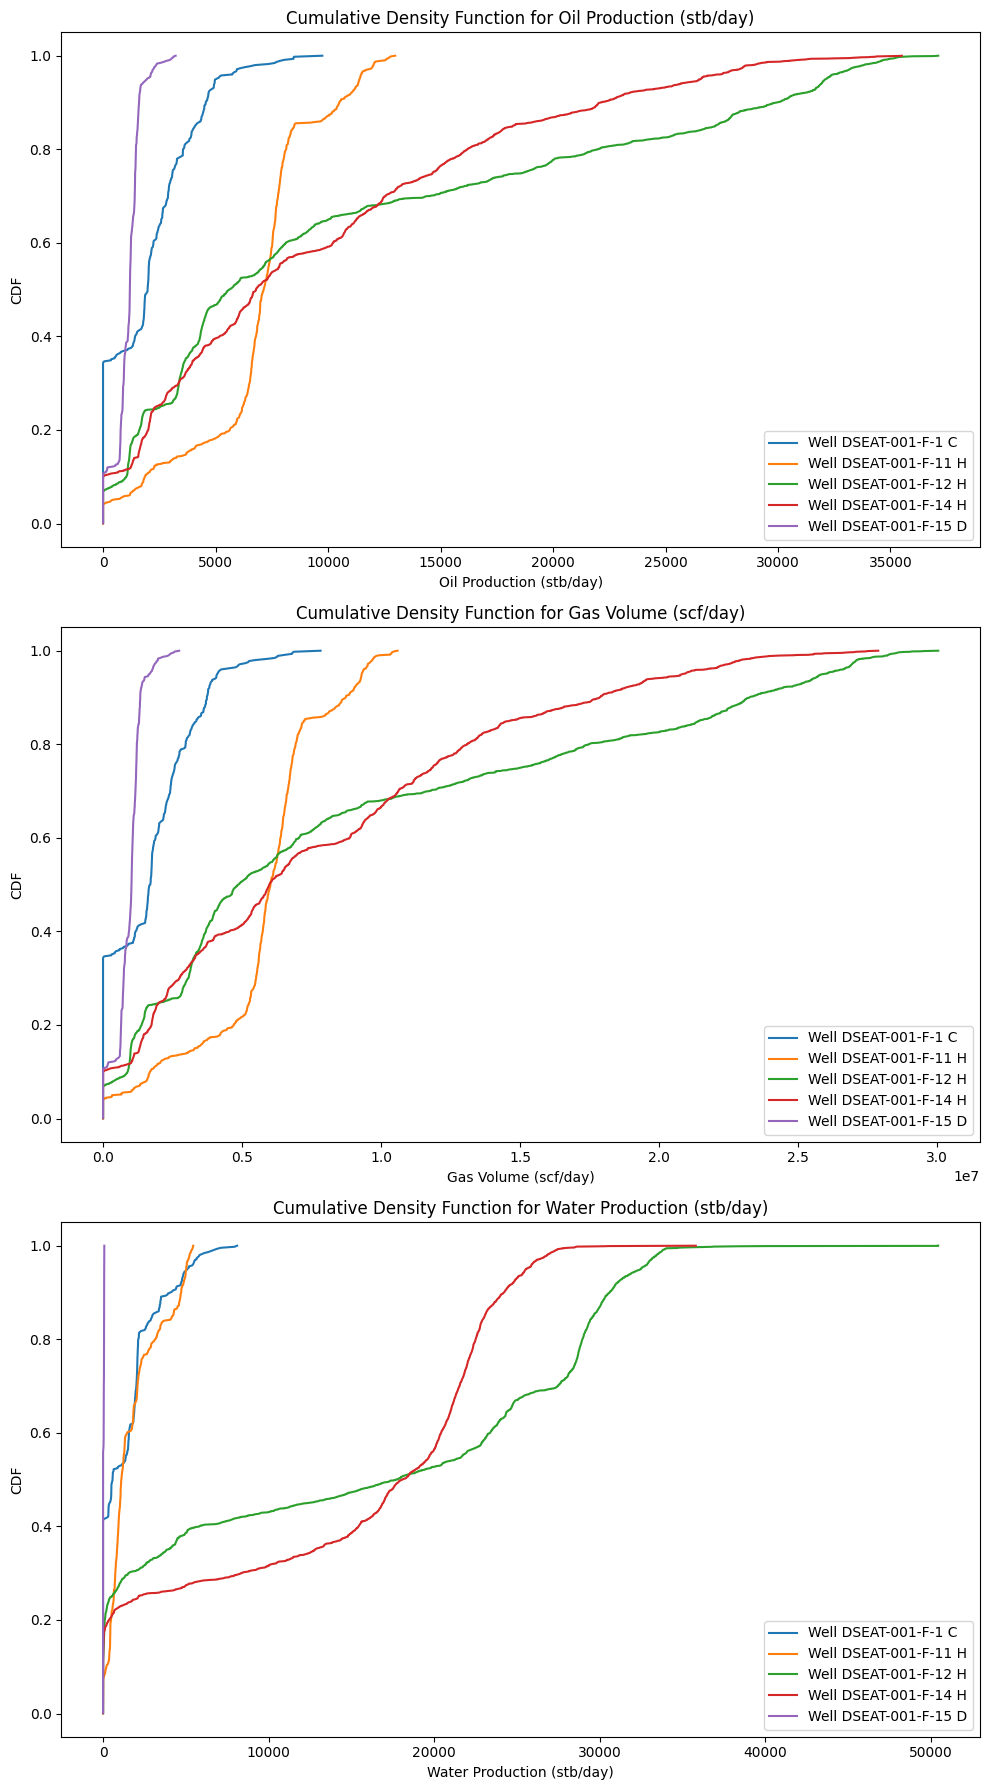

In [38]:
cdf(Data_train, 'WELL_BORE_CODE', ['Oil Production (stb/day)', 'Gas Volume (scf/day)','Water Production (stb/day)'])

From the plots, we observe that wells **DSEAT-001-F-12 H** and **DSEAT-001-F-14 H** had the highest oil and gas production. In contrast, well **DSEAT-001-F-1 C** shows a significant drop in oil and gas production for approximately **38%** of its data, indicated by the vertical line at **zero**. Additionally, well **DSEAT-001-F-15 D** has its entire water production aligned at **zero**, suggesting extremely low or no water production.

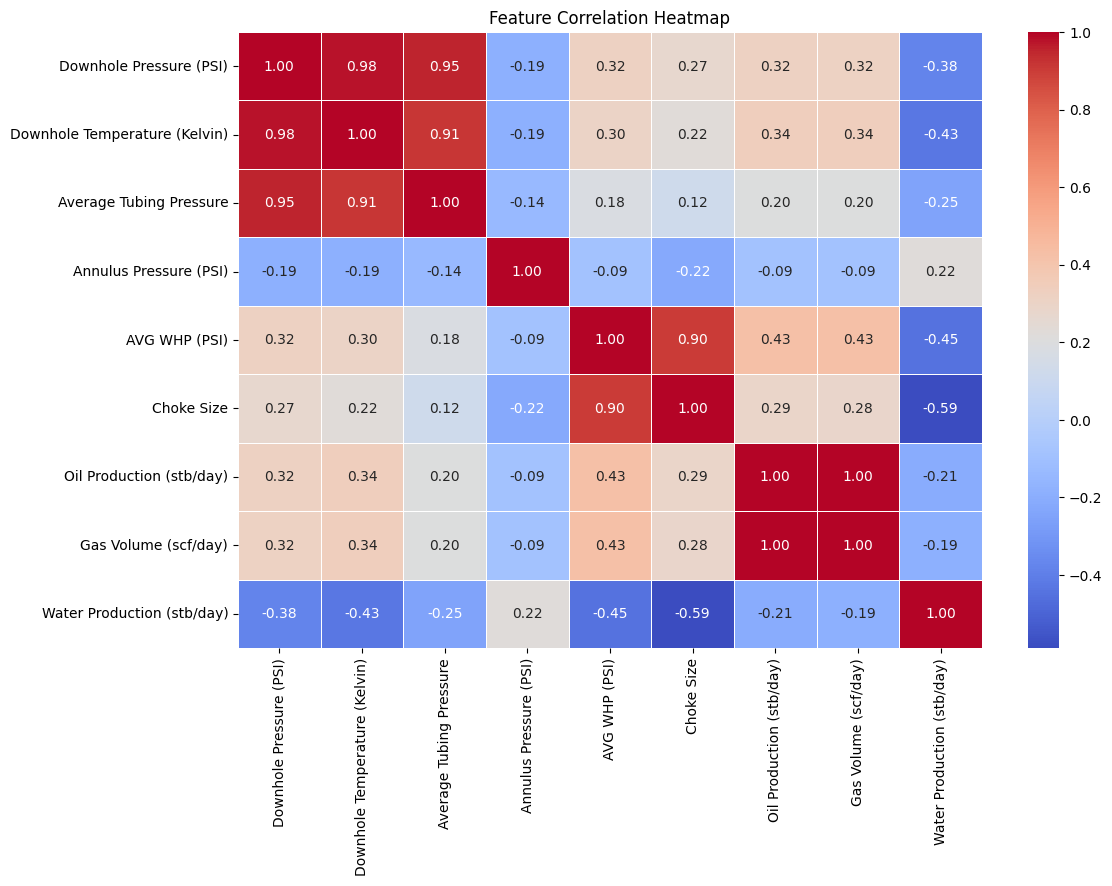

In [39]:
#plot heatmap to visualize feature correlations
def plot_heatmap(df):
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.show()

plot_heatmap(Data_train[features])


From the heatmap, we observe that the Oil and Gas produced are perfectly correlated,

The following are also positively correlated:

- downhole pressure and downhole temperature
- downhole pressure and average tubing pressure
- downhole temperature and average tubing pressure
- Average well-head pressure and choke size

For Linear models such as linear regression correlated features like this causes multi-collinearity which can confuse the model when making predictions

This insights will helps us when engineering new features, correlated features when combined properly can be very powerful during predictions

# Feature Engineering

In [40]:
num_features

['Downhole Pressure (PSI)',
 'Downhole Temperature (Kelvin)',
 'Average Tubing Pressure',
 'Annulus Pressure (PSI)',
 'AVG WHP (PSI)',
 'Choke Size']

In [41]:
def feature_engineering(df, num_features):
  
    df_transformed = df.copy()
    
    # Creating new features
    df_transformed["Pressure_diff"] = df["Downhole Pressure (PSI)"] - df["Average Tubing Pressure"]
    df_transformed["WHP_Choke Size"] = df["AVG WHP (PSI)"] * df["Choke Size"]

    #moving average
    df_transformed["AVG_WHPMA5"] = df["AVG WHP (PSI)"].rolling(window=5).mean()

    #knn imputer to fill missing values
    df_transformed[["AVG_WHPMA5"]] = imputer.fit_transform(df_transformed[["AVG_WHPMA5"]])

    # Apply standard scaling to specified numeric features
    scaler = StandardScaler()
    df_transformed[num_features] = scaler.fit_transform(df_transformed[num_features])
    return df_transformed

In [42]:
eng_features = ["Pressure_diff","WHP_Choke Size","AVG_WHPMA5"]
all_features = num_features + eng_features
fts = all_features + ["Oil Production (stb/day)","Gas Volume (scf/day)",
"Water Production (stb/day)"]
Data_train = feature_engineering(Data_train, all_features)

In [43]:
Test = Data_test.drop(["Oil Production (stb/day)","Gas Volume (scf/day)",
"Water Production (stb/day)"], axis=1)
Test.head()

Field Name   WELL_BORE_CODE  N_WELL_BORE_CODE WellBore Name  \
Date                                                                     
2015-07-01      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-02      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-03      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-04      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   
2015-07-05      DSEAT  DSEAT-001-F-1 C             105.0     001-F-1 C   

             FLOW_KIND WELL_TYPE  Downhole Pressure (PSI)  \
Date                                                        
2015-07-01  production        OP              3061.253047   
2015-07-02  production        OP              3247.951135   
2015-07-03  production        OP              3333.012485   
2015-07-04  production        OP              3404.022465   
2015-07-05  production        OP              3465.473030   

            Downhole Temperature (Kelvin)  Average Tubing Pressure  \
Date                                                                 
2015-07-01                     380.665745              2659.809580   
2015-07-02                     376.759980              2547.453670   
2015-07-03                     375.985300              2533.912265   
2015-07-04                     375.419010              2481.804485   
2015-07-05                     375.004710              2408.310945   

            Annulus Pressure (PSI)  AVG WHP (PSI)  Choke Size  
Date                                                           
2015-07-01                     0.0     401.443468    0.491632  
2015-07-02                     0.0     700.497465   21.775180  
2015-07-03                     0.0     799.100220   27.638780  
2015-07-04                     0.0     922.217980   36.178940  
2015-07-05                     0.0    1057.162085   45.424140

In [44]:
Test = Test.reset_index()

Test = feature_engineering(Test, all_features)

Test["Day"] = Test["Date"].dt.day
Test["Month"] = Test["Date"].dt.month
Test["Year"] = Test["Date"].dt.year


Test = Test.drop(columns=["Date","Field Name","WELL_BORE_CODE",
"N_WELL_BORE_CODE", "WellBore Name", "FLOW_KIND", "WELL_TYPE"])

Test.head()

Downhole Pressure (PSI)  Downhole Temperature (Kelvin)  \
0                 0.181096                       0.658160   
1                 0.297490                       0.569549   
2                 0.350519                       0.551974   
3                 0.394789                       0.539126   
4                 0.433099                       0.529727   

   Average Tubing Pressure  Annulus Pressure (PSI)  AVG WHP (PSI)  Choke Size  \
0                 0.165643               -1.654205      -0.255453   -0.505558   
1                 0.077833               -1.654205       0.629968    0.465984   
2                 0.067250               -1.654205       0.921906    0.733643   
3                 0.026526               -1.654205       1.286425    1.123481   
4                -0.030912               -1.654205       1.685959    1.545502   

   Pressure_diff  WHP_Choke Size  AVG_WHPMA5  Day  Month    Year  
0       0.157808       -0.358567    0.000000  1.0    7.0  2015.0  
1       0.758707        0.084642    0.000000  2.0    7.0  2015.0  
2       0.956832        0.285778    0.000000  3.0    7.0  2015.0  
3       1.204217        0.617791    0.000000  4.0    7.0  2015.0  
4       1.475364        1.049217    2.001381  5.0    7.0  2015.0

In [45]:
Data_train.isna().sum()

Field Name                       0
WELL_BORE_CODE                   0
N_WELL_BORE_CODE                 0
WellBore Name                    0
FLOW_KIND                        0
WELL_TYPE                        0
Downhole Pressure (PSI)          0
Downhole Temperature (Kelvin)    0
Average Tubing Pressure          0
Annulus Pressure (PSI)           0
AVG WHP (PSI)                    0
Choke Size                       0
Oil Production (stb/day)         0
Gas Volume (scf/day)             0
Water Production (stb/day)       0
Pressure_diff                    0
WHP_Choke Size                   0
AVG_WHPMA5                       0
dtype: int64

In [46]:
Train = Data_train[fts]
Train.head()

Downhole Pressure (PSI)  Downhole Temperature (Kelvin)  \
Date                                                                 
2014-04-07                -1.629029                      -1.655038   
2014-04-08                -1.629029                      -1.655038   
2014-04-09                -1.629029                      -1.655038   
2014-04-10                -1.629029                      -1.655038   
2014-04-11                 1.204369                       0.440143   

            Average Tubing Pressure  Annulus Pressure (PSI)  AVG WHP (PSI)  \
Date                                                                         
2014-04-07                -2.051612               -1.290552      -2.060107   
2014-04-08                -2.051612               -1.290552      -2.060107   
2014-04-09                -2.051612               -1.290552      -2.060107   
2014-04-10                -2.051612               -1.290552      -2.060107   
2014-04-11                 1.763665               -1.290552      -0.680374   

            Choke Size  Pressure_diff  WHP_Choke Size    AVG_WHPMA5  \
Date                                                                  
2014-04-07   -0.980939       -0.63376       -0.658725  3.464891e-16   
2014-04-08   -0.980939       -0.63376       -0.658725  3.464891e-16   
2014-04-09   -0.980939       -0.63376       -0.658725  3.464891e-16   
2014-04-10   -0.980939       -0.63376       -0.658725  3.464891e-16   
2014-04-11    0.502812        0.08106       -0.197688 -1.892283e+00   

            Oil Production (stb/day)  Gas Volume (scf/day)  \
Date                                                         
2014-04-07                       0.0                   0.0   
2014-04-08                       0.0                   0.0   
2014-04-09                       0.0                   0.0   
2014-04-10                       0.0                   0.0   
2014-04-11                       0.0                   0.0   

            Water Production (stb/day)  
Date                                    
2014-04-07                         0.0  
2014-04-08                         0.0  
2014-04-09                         0.0  
2014-04-10                         0.0  
2014-04-11                         0.0

In [47]:
#Train = Train.drop(["Downhole Temperature (Kelvin)","Average Tubing Pressure","Choke Size"], axis=1)

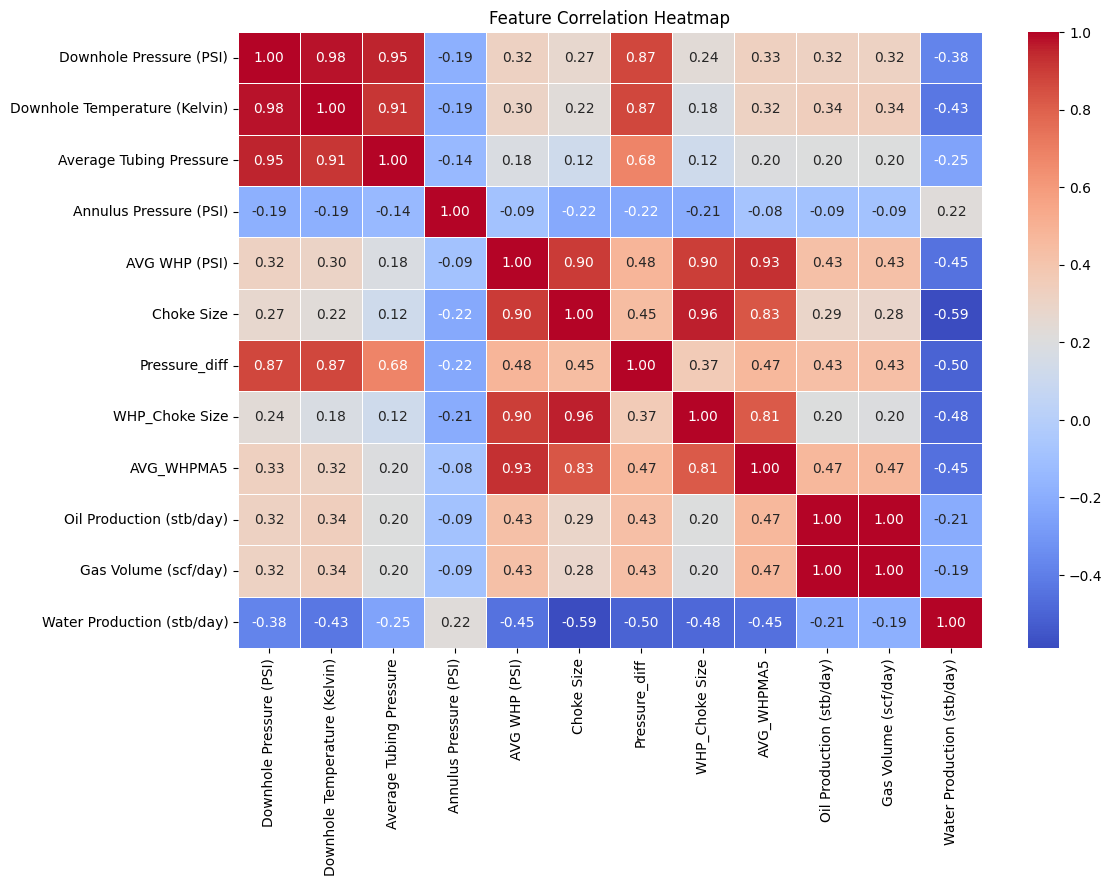

In [48]:
 plot_heatmap(Train)

In [49]:
Train = Train.reset_index()  
# Extract day, month, and year from the Date column
Train["Day"] = Train["Date"].dt.day
Train["Month"] = Train["Date"].dt.month
Train["Year"] = Train["Date"].dt.year

# Drop the original Date column
Train = Train.drop(columns=["Date","Oil Production (stb/day)","Gas Volume (scf/day)",
"Water Production (stb/day)"])

Train.head()


Downhole Pressure (PSI)  Downhole Temperature (Kelvin)  \
0                -1.629029                      -1.655038   
1                -1.629029                      -1.655038   
2                -1.629029                      -1.655038   
3                -1.629029                      -1.655038   
4                 1.204369                       0.440143   

   Average Tubing Pressure  Annulus Pressure (PSI)  AVG WHP (PSI)  Choke Size  \
0                -2.051612               -1.290552      -2.060107   -0.980939   
1                -2.051612               -1.290552      -2.060107   -0.980939   
2                -2.051612               -1.290552      -2.060107   -0.980939   
3                -2.051612               -1.290552      -2.060107   -0.980939   
4                 1.763665               -1.290552      -0.680374    0.502812   

   Pressure_diff  WHP_Choke Size    AVG_WHPMA5  Day  Month  Year  
0       -0.63376       -0.658725  3.464891e-16    7      4  2014  
1       -0.63376       -0.658725  3.464891e-16    8      4  2014  
2       -0.63376       -0.658725  3.464891e-16    9      4  2014  
3       -0.63376       -0.658725  3.464891e-16   10      4  2014  
4        0.08106       -0.197688 -1.892283e+00   11      4  2014

In [50]:
targets = Data_train[target_features]
targets = targets.reset_index()
targets = targets.drop(["Date"], axis=1)

# **BASE MODEL**

In [51]:
X_train,X_val,y_train,y_val = train_test_split(Train,targets,test_size=0.2,random_state=25)

In [52]:
def train_and_evaluate_models(X_train, X_val, y_train, y_val, cv_folds=5):
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=500, random_state=25),
        "XGBoost": xgb.XGBRegressor(n_estimators=700, random_state=25),
        "CatBoost": cbt.CatBoostRegressor(n_estimators=700, verbose=0, random_state=25)
    }

    results = {}
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=25)

    for name, model in models.items():
        multi_model = MultiOutputRegressor(model)

        cv_scores = cross_val_score(multi_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
        cv_rmse_scores = np.sqrt(-cv_scores)

        print(f"Model: {name} - Cross-validation RMSE scores: {cv_rmse_scores}")
        print(f"Mean CV RMSE: {cv_rmse_scores.mean():.4f}\n")

        # Train the model on full training data
        multi_model.fit(X_train, y_train)
        y_pred = multi_model.predict(X_val)

        # Evaluate on validation set
        rmse = np.sqrt(mean_squared_error(y_val, y_pred, multioutput='raw_values'))
        mae = mean_absolute_error(y_val, y_pred, multioutput='raw_values')
        r2 = r2_score(y_val, y_pred, multioutput='raw_values')

        results[name] = {
            "CV Mean RMSE": cv_rmse_scores.mean(),
            "Validation RMSE": rmse,
            "Validation MAE": mae,
            "Validation R²": r2
        }

        print(f"Model: {name} - Final Evaluation")
        print(f"Validation RMSE: {rmse}")
        print(f"Validation MAE: {mae}")
        print(f"Validation R² Score: {r2}")
        print("-" * 50)

    return results

In [53]:
results = train_and_evaluate_models(X_train, X_val, y_train, y_val)

Model: Linear Regression - Cross-validation RMSE scores: [1884782.087812   2003177.56591635 2074031.05657236 2059846.89011715
 1970693.0555467 ]
Mean CV RMSE: 1998506.1312

Model: Linear Regression - Final Evaluation
Validation RMSE: [   4493.73256171 3552497.25630155    6678.90335806]
Validation MAE: [   3104.0158362  2424052.89963064    4975.81634057]
Validation R² Score: [0.74108679 0.74513124 0.66783633]
--------------------------------------------------
Model: Random Forest - Cross-validation RMSE scores: [791863.18858709 693483.32630771 962916.39117683 792686.94452591
 872671.59724617]
Mean CV RMSE: 822724.2896

Model: Random Forest - Final Evaluation
Validation RMSE: [   1923.22432871 1576003.00368694    2794.1171937 ]
Validation MAE: [   665.51535807 562897.87819764    997.62502814]
Validation R² Score: [0.95257584 0.94983935 0.94186589]
--------------------------------------------------
Model: XGBoost - Cross-validation RMSE scores: [ 841803.99602484  709624.10006831 1026971.9

Random Forest performed Best

In [54]:
#hyper parameter tuning
param_dist = {
    "estimator__n_estimators": [200, 300, 500, 700, 1000],  
    "estimator__max_depth": [10, 15, 20, 30],  
    "estimator__min_samples_split": [2, 5, 10],  
    "estimator__min_samples_leaf": [1, 2, 4],  
 
}

rf = MultiOutputRegressor(RandomForestRegressor(random_state=25))

random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, 
    n_iter=20, scoring='neg_mean_squared_error', cv=5, 
    random_state=25, verbose=1, n_jobs=-1
)


random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best RMSE Score:", np.sqrt(-random_search.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'estimator__n_estimators': 700, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 20}
Best RMSE Score: 837886.6298761672


In [55]:
from scipy.stats import uniform, randint, loguniform

param_dist_xgb = {
    "estimator__n_estimators": randint(500, 1500),  
    "estimator__max_depth": randint(3, 15),  
    "estimator__learning_rate": loguniform(1e-3, 0.2),  
    "estimator__subsample": uniform(0.6, 0.4),  
    "estimator__gamma": uniform(0, 0.3), 
    "estimator__reg_alpha": uniform(0, 1.0),  
}


xgb = MultiOutputRegressor(xgb.XGBRegressor(random_state=25, n_jobs=-1))

random_search_xgb = RandomizedSearchCV(
    xgb, param_distributions=param_dist_xgb, 
    n_iter=20, scoring='neg_mean_squared_error', cv=5, 
    random_state=25, verbose=1, n_jobs=-1
)

random_search_xgb.fit(X_train, y_train)

print("Best Parameters:", random_search_xgb.best_params_)
print("Best RMSE Score:", np.sqrt(-random_search_xgb.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'estimator__gamma': 0.26103724098816355, 'estimator__learning_rate': 0.021869390461794293, 'estimator__max_depth': 9, 'estimator__n_estimators': 755, 'estimator__reg_alpha': 0.1808245510689923, 'estimator__subsample': 0.6602472219388947}
Best RMSE Score: 817172.0652522801


In [56]:
# Get best model
best_rf_model = random_search.best_estimator_

# Predict on validation set
y_pred = best_rf_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred, multioutput='raw_values'))
mae = mean_absolute_error(y_val, y_pred, multioutput='raw_values')
r2 = r2_score(y_val, y_pred, multioutput='raw_values')

print("\nFinal Evaluation on Validation Set:")
print(f"Validation RMSE: {rmse}")
print(f"Validation MAE: {mae}")
print(f"Validation R² Score: {r2}")



Final Evaluation on Validation Set:
Validation RMSE: [   1927.53115574 1570386.61793756    2811.20166838]
Validation MAE: [   666.11345218 561661.89376296   1003.43689367]
Validation R² Score: [0.9523632  0.95019622 0.9411528 ]


In [57]:
# Get best model
best_xgb_model = random_search_xgb.best_estimator_

# Predict on validation set
xgb_pred = best_xgb_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, xgb_pred, multioutput='raw_values'))
mae = mean_absolute_error(y_val, xgb_pred, multioutput='raw_values')
r2 = r2_score(y_val, xgb_pred, multioutput='raw_values')

print("\nFinal Evaluation on Validation Set:")
print(f"Validation RMSE: {rmse}")
print(f"Validation MAE: {mae}")
print(f"Validation R² Score: {r2}")



Final Evaluation on Validation Set:
Validation RMSE: [   1895.34721842 1520433.10788145    2931.23837558]
Validation MAE: [   647.31879091 545308.5008449    1033.86547903]
Validation R² Score: [0.9539407  0.95331432 0.93602002]


In [58]:
Test.columns, Train.columns

(Index(['Downhole Pressure (PSI)', 'Downhole Temperature (Kelvin)',
        'Average Tubing Pressure', 'Annulus Pressure (PSI)', 'AVG WHP (PSI)',
        'Choke Size', 'Pressure_diff', 'WHP_Choke Size', 'AVG_WHPMA5', 'Day',
        'Month', 'Year'],
       dtype='object'),
 Index(['Downhole Pressure (PSI)', 'Downhole Temperature (Kelvin)',
        'Average Tubing Pressure', 'Annulus Pressure (PSI)', 'AVG WHP (PSI)',
        'Choke Size', 'Pressure_diff', 'WHP_Choke Size', 'AVG_WHPMA5', 'Day',
        'Month', 'Year'],
       dtype='object'))

In [59]:
Test

Downhole Pressure (PSI)  Downhole Temperature (Kelvin)  \
0                    0.181096                       0.658160   
1                    0.297490                       0.569549   
2                    0.350519                       0.551974   
3                    0.394789                       0.539126   
4                    0.433099                       0.529727   
...                       ...                            ...   
9915                      NaN                            NaN   
9916                      NaN                            NaN   
9917                      NaN                            NaN   
9918                      NaN                            NaN   
9919                      NaN                            NaN   

      Average Tubing Pressure  Annulus Pressure (PSI)  AVG WHP (PSI)  \
0                    0.165643               -1.654205      -0.255453   
1                    0.077833               -1.654205       0.629968   
2                    0.067250               -1.654205       0.921906   
3                    0.026526               -1.654205       1.286425   
4                   -0.030912               -1.654205       1.685959   
...                       ...                     ...            ...   
9915                      NaN                     NaN            NaN   
9916                      NaN                     NaN            NaN   
9917                      NaN                     NaN            NaN   
9918                      NaN                     NaN            NaN   
9919                      NaN                     NaN            NaN   

      Choke Size  Pressure_diff  WHP_Choke Size  AVG_WHPMA5  Day  Month  \
0      -0.505558       0.157808       -0.358567    0.000000  1.0    7.0   
1       0.465984       0.758707        0.084642    0.000000  2.0    7.0   
2       0.733643       0.956832        0.285778    0.000000  3.0    7.0   
3       1.123481       1.204217        0.617791    0.000000  4.0    7.0   
4       1.545502       1.475364        1.049217    2.001381  5.0    7.0   
...          ...            ...             ...         ...  ...    ...   
9915         NaN            NaN             NaN    0.000000  NaN    NaN   
9916         NaN            NaN             NaN    0.000000  NaN    NaN   
9917         NaN            NaN             NaN    0.000000  NaN    NaN   
9918         NaN            NaN             NaN    0.000000  NaN    NaN   
9919         NaN            NaN             NaN    0.000000  NaN    NaN   

        Year  
0     2015.0  
1     2015.0  
2     2015.0  
3     2015.0  
4     2015.0  
...      ...  
9915     NaN  
9916     NaN  
9917     NaN  
9918     NaN  
9919     NaN  

[9920 rows x 12 columns]

In [61]:
# Predict on the test data using the best model
Test = Test.dropna()
test_preds = best_rf_model.predict(Test)

test_preds_df = pd.DataFrame(test_preds, columns=["Oil Production (stb/day)","Gas Volume (scf/day)","Water Production (stb/day)"])

test_with_preds = Test.copy()  
test_with_preds = test_with_preds.reset_index() 
test_with_preds = pd.concat([test_with_preds, test_preds_df], axis=1)

In [64]:
# Display the final test dataset with predictions
test_with_preds.head()

index  Downhole Pressure (PSI)  Downhole Temperature (Kelvin)  \
0      0                 0.181096                       0.658160   
1      1                 0.297490                       0.569549   
2      2                 0.350519                       0.551974   
3      3                 0.394789                       0.539126   
4      4                 0.433099                       0.529727   

   Average Tubing Pressure  Annulus Pressure (PSI)  AVG WHP (PSI)  Choke Size  \
0                 0.165643               -1.654205      -0.255453   -0.505558   
1                 0.077833               -1.654205       0.629968    0.465984   
2                 0.067250               -1.654205       0.921906    0.733643   
3                 0.026526               -1.654205       1.286425    1.123481   
4                -0.030912               -1.654205       1.685959    1.545502   

   Pressure_diff  WHP_Choke Size  AVG_WHPMA5  Day  Month    Year  \
0       0.157808       -0.358567    0.000000  1.0    7.0  2015.0   
1       0.758707        0.084642    0.000000  2.0    7.0  2015.0   
2       0.956832        0.285778    0.000000  3.0    7.0  2015.0   
3       1.204217        0.617791    0.000000  4.0    7.0  2015.0   
4       1.475364        1.049217    2.001381  5.0    7.0  2015.0   

   Oil Production (stb/day)  Gas Volume (scf/day)  Water Production (stb/day)  
0               1609.262047          1.551663e+06                  323.120445  
1                135.061126          2.690333e+04                  332.801533  
2                102.806546          2.090235e+04                  488.127367  
3                 60.346979          9.237001e+00                 1475.488791  
4                 57.769966          1.178521e+04                  540.939743